## Parameter Estimation with CMA-ES in PyBOP

In this notebook, we demonstrate an example of parameter estimation for a single-particle model using the Covariance Matrix Adaptation Evolution Strategy (CMA-ES). CMA-ES is an evolutionary algorithm for difficult non-linear, non-convex optimization problems.

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP from its development branch and upgrade some dependencies:

In [1]:
%pip install --upgrade pip ipywidgets
%pip install pybop -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [2]:
import pybop
import numpy as np

### Generate Synthetic Data

To demonstrate parameter estimation, we first need synthetic data. This data will be generated using the PyBOP forward model, which requires defining a parameter set and the model itself.

#### Defining Parameters and Model

We start by creating an example parameter set and then instantiate the single-particle model (SPM):

In [3]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
model = pybop.lithium_ion.SPM(parameter_set=parameter_set)

### Simulating Forward Model

We can then simulate the model using the `predict` method, with a default constant current to generate voltage data.

In [4]:
t_eval = np.arange(0, 900, 2)
values = model.predict(t_eval=t_eval)

### Adding Noise to Voltage Data

To make the parameter estimation more realistic, we add Gaussian noise to the data.

In [5]:
sigma = 0.001
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

## Identify the Parameters

We will now set up the parameter estimation process by defining the datasets for optimisation and selecting the model parameters we wish to estimate.

### Creating Optimization Dataset

The dataset for optimization is composed of time, current, and the noisy voltage data:

In [6]:
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Defining Parameters to Estimate

We select the parameters for estimation and set up their prior distributions and bounds:

In [7]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.7, 0.05),
        bounds=[0.6, 0.9],
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.58, 0.05),
        bounds=[0.5, 0.8],
    ),
]

### Setting up the Optimization Problem

With the datasets and parameters defined, we can set up the optimization problem, its cost function, and the optimizer.

In [8]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)
optim = pybop.Optimisation(cost, optimiser=pybop.CMAES)
optim.set_max_iterations(100)

### Running the Optimization

We proceed to run the CMA-ES optimization algorithm to estimate the parameters:

In [9]:
x, final_cost = optim.run()

### Viewing the Estimated Parameters

After the optimization, we can examine the estimated parameter values:

In [10]:
x  # This will output the estimated parameters

array([0.74839253, 0.66530766])

## Plotting and Visualization

PyBOP provides various plotting utilities to visualize the results of the optimization.

### Comparing System Response

We can quickly plot the system's response using the estimated parameters compared to the target:

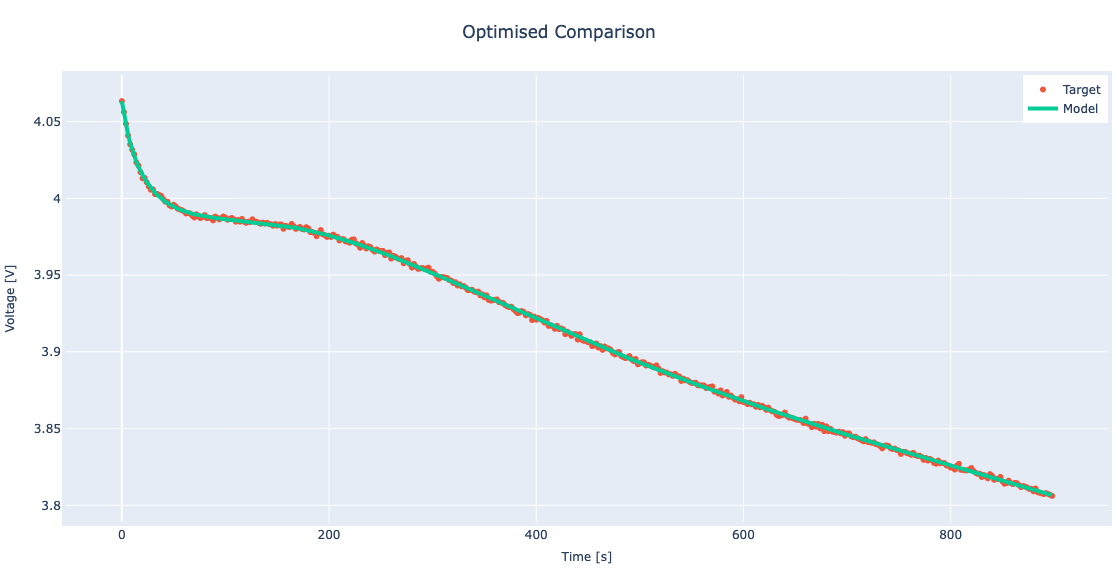

In [14]:
pybop.quick_plot(x, cost, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimization process, we can plot the convergence of the cost function and the trajectories of the parameters:

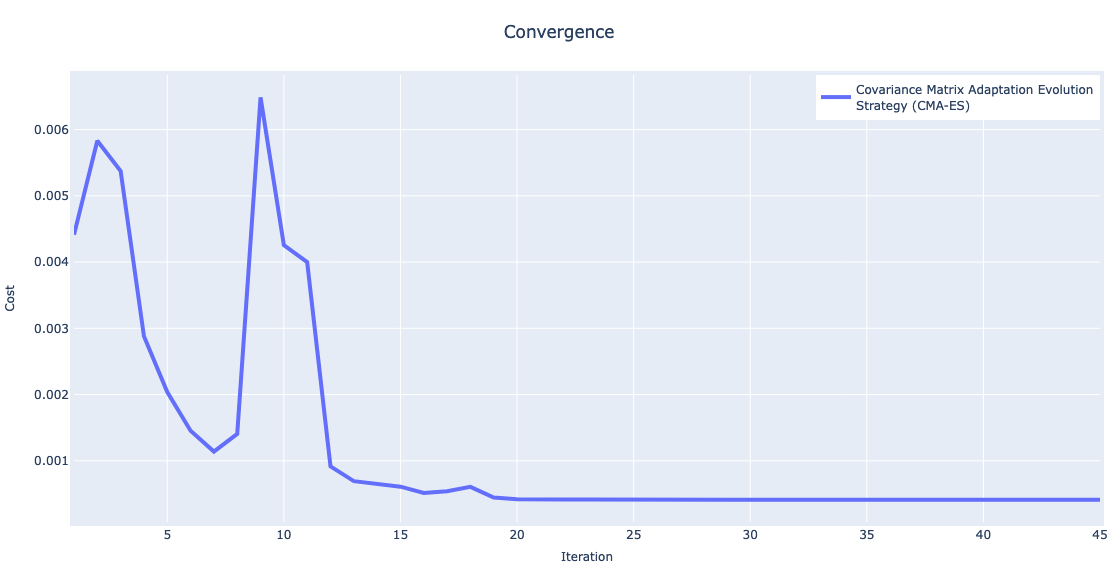

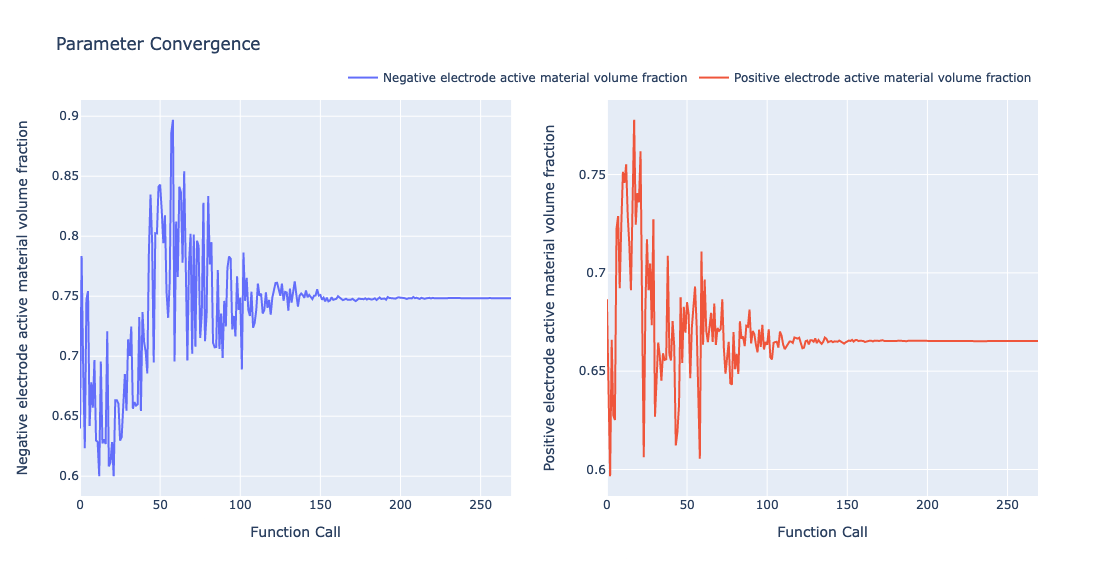

In [15]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

### Cost Landscape

Finally, we can visualize the cost landscape and the path taken by the optimizer:

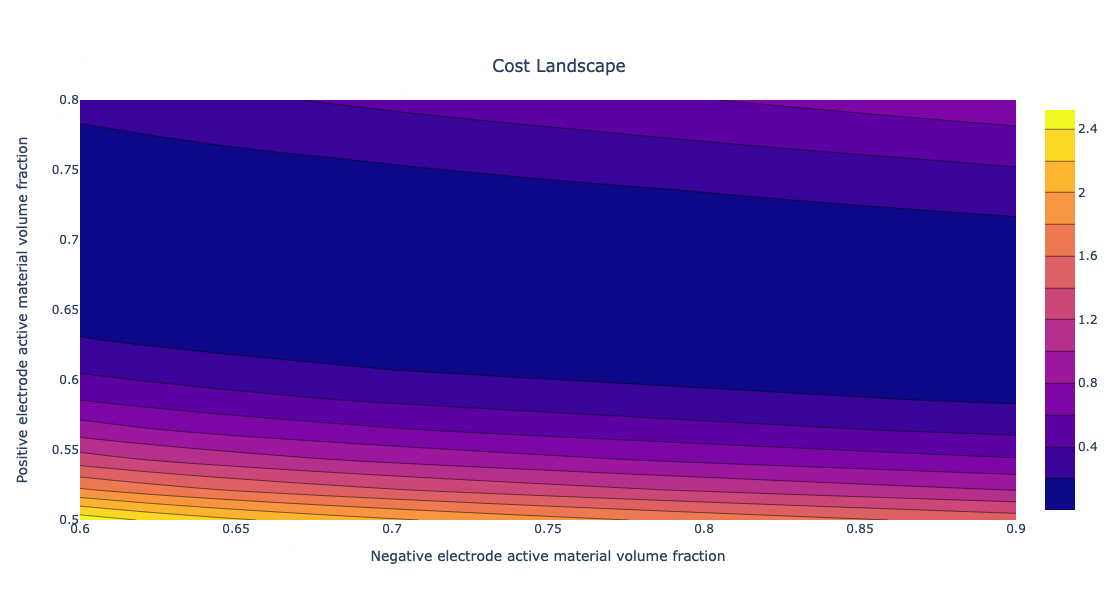

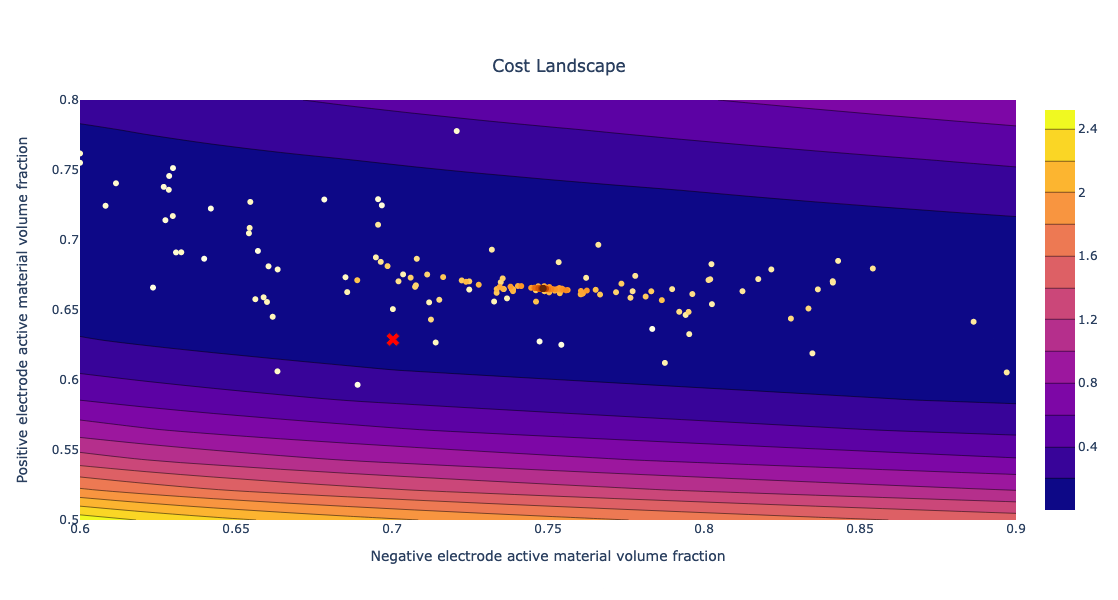

In [16]:
# Plot the cost landscape
pybop.plot_cost2d(cost, steps=15)
# Plot the cost landscape with optimisation path and updated bounds
bounds = np.array([[0.6, 0.9], [0.5, 0.8]])
pybop.plot_cost2d(cost, optim=optim, bounds=bounds, steps=15);

### Conclusion

This notebook illustrates how to perform parameter estimation using CMA-ES in PyBOP, providing insights into the optimization process through various visualizations.